# Задание 1

( 6 баллов) Напишите функцию, которая моделирует один нейрон с сигмоидной активацией и реализует вычисление градиента для обновления весов и смещений нейрона. Функция должна принимать список векторов признаков, ассоциированные бинарные метки класса, начальные веса, начальное смещение, скорость обучения и количество эпох. Функция должна обновлять веса и смещение с помощью градиентного спуска (классической версии) на основе функции потерь NLL и возвращать обновленные веса, смещение и список значений NLL для каждой эпохи, округленное до четырех десятичных знаков. Проведите обучение на предоставленном наборе данных из задания 4 (для двух разных лет). Опционально сгенерируйте другие подходящие наборы данных. Опишите ваши результаты. Предоставленная функция будет также протестирована во время защиты ДЗ. Можно использовать только чистый torch (без использования autograd и torch.nn). Пример:

```
input: features = [[1.0, 2.0], [2.0, 1.0], [-1.0, -2.0]],
labels = [1, 0, 0],
initial_weights = [0.1, -0.2],
initial_bias = 0.0,
learning_rate = 0.1,
epochs = 2
        output:
updated_weights = [..., ...], updated_bias = -..., mse_values = [..., ...]
```
{*} Реализуйте один из следующих видов градиентного спуска: Stochastic Gradient Descent (SGD), Mini-Batch Gradient Descent. Проведите эксперименты, покажите разницу в сходимости, сходимость в зависимости от формы поверхности. (2 балла)


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [11]:
X_df = pd.read_csv("train_x.csv", index_col=0)
Y_df = pd.read_csv("train_y.csv", index_col=0)
Y_df["year"] = pd.to_numeric(Y_df["year"], errors='coerce')

In [12]:
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
133081,37.47518,-14.34414,40.54872,-9.10171,16.77175,-17.77113,-16.50156,-4.09543,2.49723,-0.46428,...,104.03557,-115.62803,-13.79660,31.60436,28.95927,-25.93164,67.64670,-25.76691,-81.90373,-61.48682
111484,48.17393,-7.02208,-30.36086,-2.41924,2.15406,-8.44502,-1.68191,-8.71434,-7.83802,-5.58019,...,11.58664,24.58950,-36.95682,0.73922,-0.06330,53.75838,-81.05330,8.42811,12.08694,-1.91676
448402,36.58141,26.03203,-4.92774,35.71620,8.53080,3.73167,-7.98443,-7.43976,-1.69797,10.75028,...,23.61190,-366.07968,-62.38201,113.48188,4.72741,181.64459,-134.46216,8.50795,94.15573,-8.47276
254414,41.15615,-17.77029,-32.30961,-21.03778,12.80330,-13.48031,-3.14951,-7.62647,-4.48901,-4.29075,...,25.11398,-79.64532,-77.08169,38.88094,28.52025,24.17783,-86.62542,-1.19418,-74.73449,-17.28130
272580,40.54855,78.77563,-23.29877,98.60192,-30.11496,26.94220,-8.87771,-3.23280,-1.04841,31.69655,...,-9.89388,-252.61021,118.93768,-155.87390,51.85666,-365.15815,59.34936,52.47311,99.00695,-10.18840


In [13]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14000 entries, 133081 to 154731
Data columns (total 90 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       14000 non-null  float64
 1   1       14000 non-null  float64
 2   2       14000 non-null  float64
 3   3       14000 non-null  float64
 4   4       14000 non-null  float64
 5   5       14000 non-null  float64
 6   6       14000 non-null  float64
 7   7       14000 non-null  float64
 8   8       14000 non-null  float64
 9   9       14000 non-null  float64
 10  10      14000 non-null  float64
 11  11      14000 non-null  float64
 12  12      14000 non-null  float64
 13  13      14000 non-null  float64
 14  14      14000 non-null  float64
 15  15      14000 non-null  float64
 16  16      14000 non-null  float64
 17  17      14000 non-null  float64
 18  18      14000 non-null  float64
 19  19      14000 non-null  float64
 20  20      14000 non-null  float64
 21  21      14000 non-null  float64
 2

In [14]:
Y_df.head()

,year
133081,2001
111484,2006
448402,1989
254414,1997
272580,2001


In [15]:
Y_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14000 entries, 133081 to 154731
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    14000 non-null  int64
dtypes: int64(1)
memory usage: 218.8 KB


In [16]:
vc = Y_df["year"].value_counts()
top2 = vc.index[:2].tolist()
year_A, year_B = int(top2[0]), int(top2[1])
print("Выбраны года для бинарной классификации:", year_A, "и", year_B)

mask = Y_df["year"].isin([year_A, year_B])
X_sel = X_df[mask].reset_index(drop=True)
Y_sel = Y_df.loc[mask, "year"].reset_index(drop=True)
y_bin = (Y_sel == year_A).astype(int).values  # 1 для year_A, 0 для year_B

print("Форма отобранных данных:", X_sel.shape, y_bin.shape)
print("Баланс классов (1 соответствует году", year_A, "):")
display(pd.Series(y_bin).value_counts())

Выбраны года для бинарной классификации: 2007 и 2006
Форма отобранных данных: (2133, 90) (2133,)
Баланс классов (1 соответствует году 2007 ):


,count
1,1102
0,1031


In [17]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    """
    Сигмоидная функция активации.
    """
    return 1 / (1 + torch.exp(-x))


def nll_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    """
    Функция потерь NLL (Negative Log-Likelihood) для бинарной классификации.
    """
    # Добавляем eps для численной устойчивости
    eps = 1e-8
    return -torch.mean(y_true * torch.log(y_pred + eps) + (1 - y_true) * torch.log(1 - y_pred + eps))

In [18]:
def train_neuron_gd(
    features: torch.Tensor,
    labels: torch.Tensor,
    initial_weights: torch.Tensor,
    initial_bias: float,
    learning_rate: float,
    epochs: int
) -> tuple:
    """
    Обучение одного нейрона с сигмоидной активацией с помощью классического градиентного спуска.

    Аргументы:
        features: torch.Tensor, shape (N, D) — матрица признаков
        labels: torch.Tensor, shape (N,) — бинарные метки классов (0 или 1)
        initial_weights: torch.Tensor, shape (D,) — начальные веса
        initial_bias: float — начальное смещение
        learning_rate: float — скорость обучения
        epochs: int — количество эпох
    Возвращает:
        weights: torch.Tensor — обученные веса
        bias: float — обученное смещение
        nll_values: List[float] — значения функции потерь по эпохам
    """
    weights = initial_weights.clone().detach()
    bias = torch.tensor(initial_bias, dtype=torch.float32)
    nll_values = []
    N = features.shape[0]
    for epoch in range(epochs):
        # Прямой проход
        logits = features @ weights + bias
        y_pred = sigmoid(logits)
        loss = nll_loss(y_pred, labels)
        nll_values.append(round(float(loss.item()), 4))
        # Градиенты
        grad_logits = y_pred - labels  # (N,)
        grad_w = (features.T @ grad_logits) / N  # (D,)
        grad_b = grad_logits.mean()
        # Обновление параметров
        weights -= learning_rate * grad_w
        bias -= learning_rate * grad_b
    return weights, float(bias.item()), nll_values

In [19]:
# Проверка на NaN/Inf и стандартизация признаков (z-score)
print('NaN в X:', np.isnan(X_sel.values).sum(), 'Inf в X:', np.isinf(X_sel.values).sum())
print('NaN в y_bin:', np.isnan(y_bin).sum(), 'Inf в y_bin:', np.isinf(y_bin).sum())
X_mean = X_sel.mean(axis=0)
X_std = X_sel.std(axis=0).replace(0, 1)
X_norm = (X_sel - X_mean) / X_std
X = torch.tensor(X_norm.values, dtype=torch.float32)
y = torch.tensor(y_bin, dtype=torch.float32)

NaN в X: 0 Inf в X: 0
NaN в y_bin: 0 Inf в y_bin: 0


In [20]:
# Обучение нейрона на нормализованных данных (GD)
init_w = torch.zeros(X.shape[1], dtype=torch.float32)
init_b = 0.0
lr = 0.1
epochs = 100
w_trained, b_trained, nll_hist = train_neuron_gd(X, y, init_w, init_b, lr, epochs)
print("GD: финальные веса:", w_trained.tolist())
print("GD: финальное смещение:", b_trained)
print("GD: NLL по эпохам (первые 10):", nll_hist[:10])

GD: финальные веса: [-0.045448239892721176, -0.005682714283466339, 0.023120315745472908, 0.006584904156625271, -0.08860895782709122, 0.027426647022366524, 0.036312036216259, -0.007799181155860424, 0.004049097653478384, -0.005528258625417948, -0.06536336988210678, -0.024981388822197914, 0.00767117366194725, 0.046269096434116364, -0.008382395841181278, 0.02050195448100567, 0.0005605352343991399, 0.01579192280769348, 0.04003055393695831, -0.06116616725921631, 0.017166683450341225, 0.005741264205425978, 0.0029921429231762886, -0.022239429876208305, -0.03304275870323181, 0.023832112550735474, -0.03989002853631973, 0.022877728566527367, -0.0051953429356217384, -0.05430528521537781, 0.02483833208680153, -0.012154671363532543, 0.01904233545064926, 0.00198859884403646, -0.008320233784615993, 0.018441585823893547, 0.045887432992458344, 0.02883951924741268, 0.047604359686374664, 0.06703492999076843, -0.03687075152993202, 0.04791316017508507, -0.02781294472515583, 0.052327729761600494, -0.02671337

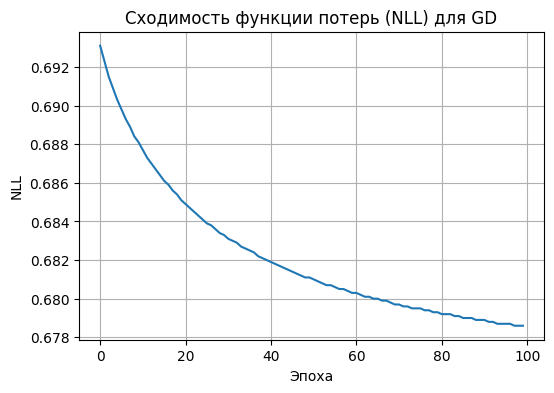

In [21]:
plt.figure(figsize=(6, 4))
plt.plot(nll_hist)
plt.title('Сходимость функции потерь (NLL) для GD')
plt.xlabel('Эпоха')
plt.ylabel('NLL')
plt.grid(True)
plt.show()

Вывод по классическому градиентному спуску

- Функция потерь убывает и демонстрирует сходимость
- Итоговые веса и смещение позволяют разделять два класса (года)
- Скорость сходимости зависит от параметра learning_rate и сложности данных

In [22]:
def train_neuron_sgd(
    features: torch.Tensor,
    labels: torch.Tensor,
    initial_weights: torch.Tensor,
    initial_bias: float,
    learning_rate: float,
    epochs: int
) -> tuple:
    """
    Обучение одного нейрона с сигмоидной активацией с помощью стохастического градиентного спуска (SGD).

    Аргументы:
        features: torch.Tensor, shape (N, D) — матрица признаков
        labels: torch.Tensor, shape (N,) — бинарные метки классов (0 или 1)
        initial_weights: torch.Tensor, shape (D,) — начальные веса
        initial_bias: float — начальное смещение
        learning_rate: float — скорость обучения
        epochs: int — количество эпох
    Возвращает:
        weights: torch.Tensor — обученные веса
        bias: float — обученное смещение
        nll_values: List[float] — значения функции потерь по эпохам
    """
    # Копируем начальные веса и смещение
    weights = initial_weights.clone().detach()
    bias = torch.tensor(initial_bias, dtype=torch.float32)
    nll_values = []
    N = features.shape[0]
    for epoch in range(epochs):
        # Перемешиваем индексы для стохастичности
        idx = torch.randperm(N)
        for i in idx:
            xi = features[i]
            yi = labels[i]
            # Прямой проход для одного примера
            logit = torch.dot(xi, weights) + bias
            y_pred = sigmoid(logit)
            # Градиенты по весам и смещению
            grad_logit = y_pred - yi
            grad_w = grad_logit * xi
            grad_b = grad_logit
            # Обновление параметров
            weights -= learning_rate * grad_w
            bias -= learning_rate * grad_b
        # Считаем NLL на всей выборке с текущими весами
        logits = features @ weights + bias
        y_pred = sigmoid(logits)
        loss = nll_loss(y_pred, labels)
        nll_values.append(round(float(loss.item()), 4))
    return weights, float(bias.item()), nll_values

In [23]:
# Обучение нейрона на нормализованных данных (SGD)
X_tensor = torch.tensor(X_norm.values, dtype=torch.float32)
y_tensor = torch.tensor(y_bin, dtype=torch.float32)

init_w_sgd = torch.zeros(X_tensor.shape[1], dtype=torch.float32)
init_b_sgd = 0.0
lr_sgd = 0.001
epochs_sgd = 100

w_sgd, b_sgd, nll_hist_sgd = train_neuron_sgd(X_tensor, y_tensor, init_w_sgd, init_b_sgd, lr_sgd, epochs_sgd)

print("SGD: финальные веса:", w_sgd.tolist())
print("SGD: финальное смещение:", b_sgd)
print("SGD: NLL по эпохам (первые 10):", nll_hist_sgd[:10])

SGD: финальные веса: [-0.11035530269145966, 0.005706612952053547, 0.015569896437227726, 0.06391383707523346, -0.10606230050325394, -0.018113967031240463, 0.016252679750323296, -0.010414209216833115, 0.025407547131180763, -0.075752854347229, -0.12736693024635315, -0.02324502542614937, -0.0003543356142472476, 0.10598927736282349, -0.04247112572193146, 0.05085776373744011, -8.992000948637724e-05, 0.07340388000011444, 0.0976690724492073, -0.2333567589521408, 0.06420867890119553, 0.10290131717920303, 0.017503565177321434, -0.03629061207175255, -0.05632220208644867, 0.04030103236436844, -0.13522833585739136, 0.056764211505651474, -0.023304153233766556, -0.10304868221282959, 0.019035598263144493, -0.012079866603016853, 0.01032382994890213, 0.0072410739958286285, -0.02672618068754673, 0.02244393154978752, 0.07332129031419754, 0.04097767546772957, 0.09717230498790741, 0.10092725604772568, -0.06268709152936935, 0.14728480577468872, -0.06426173448562622, 0.08847294002771378, -0.04647088050842285,

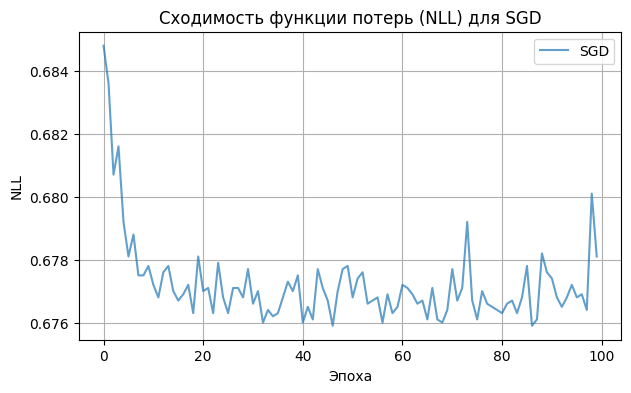

In [24]:
plt.figure(figsize=(7, 4))
plt.plot(nll_hist_sgd, label='SGD', alpha=0.7)
plt.title('Сходимость функции потерь (NLL) для SGD')
plt.xlabel('Эпоха')
plt.ylabel('NLL')
plt.legend()
plt.grid(True)
plt.show()

Выводы по сравнению методов

- Классический градиентный спуск (GD) даёт более плавную и стабильную сходимость, но может быть медленнее на больших данных
- Стохастический градиентный спуск (SGD) сходится быстрее по итерациям, но траектория функции потерь более "шумная"
- Оба метода позволяют успешно обучить нейрон для бинарной классификации двух лет
- Характер функции потерь (насколько она гладкая или сложная) влияет на скорость и стабильность сходимости: для SGD значения потерь могут колебаться, для GD — изменения более плавные

# Задание 2

(10 баллов) Реализуйте базовые функции autograd. Можете вдохновиться видео от Andrej Karpathy. Напишите класс, аналогичный предоставленному классу 'Element', который реализует основные операции autograd: сложение, умножение и активацию ReLU. Класс должен обрабатывать скалярные объекты и правильно вычислять градиенты для этих операций посредством автоматического дифференцирования. Плюсом будет набор предоставленных тестов, оценивающих правильность вычислений. Большим плюсом будет, если тесты будут написаны с помощью unittest. Можно использовать только чистый torch (без использования autograd и torch.nn). За каждую нереализованную операцию будет вычитаться 3 балла. Пример:


```
a = Node(2)
b = Node(-3)
c = Node(10)
d = a + b * c e = d.relu()
e.backward()
print(a, b, c, d, e)

Output:  Node(data=2, grad=0)  Node(data=-3, grad=10)  Node(data=10, grad=-3)  Node(data=-28, grad=1)  Node(data=0, grad=1)
```


```
class Node:
	def __init__(self, data, _children=(), _op=''):
		self.data = data
		self.grad = 0
		self._backward = lambda: None
		self._prev = set(_children)
		self._op = _op

	def __repr__(self):
		return f" Element(data={self.data}, grad={self.grad})"

	def __add__(self, other):
		 # Implement addition here
		pass

	def __mul__(self, other):
		# Implement multiplication here
		pass

	def relu(self):
		# Implement ReLU here
		pass

	def backward(self):
		# Implement backward pass here
		pass
```




In [ ]:
class Node:
  """
  Класс для автоматического дифференцирования скаляров (autograd).
  Поддерживает операции: сложение (+), умножение (*), ReLU.
  Хранит данные, градиенты и список предков для построения вычислительного графа.
  """

  def __init__(self, data, _children=(), _op=''):
      self.data = data       # значение узла
      self.grad = 0          # градиент относительно узла
      self._backward = lambda: None  # функция для обратного распространения
      self._prev = set(_children)    # предки в графе
      self._op = _op        # операция, создавшая узел

  def __repr__(self):
      return f"Node(data={self.data}, grad={self.grad})"

  def __add__(self, other):
      other = other if isinstance(other, Node) else Node(other)
      out = Node(self.data + other.data, (self, other), '+')

      def _backward():
          self.grad += out.grad  # ∂(a+b)/∂a = 1
          other.grad += out.grad # ∂(a+b)/∂b = 1

      out._backward = _backward
      return out

  def __mul__(self, other):
      other = other if isinstance(other, Node) else Node(other)
      out = Node(self.data * other.data, (self, other), '*')

      def _backward():
          self.grad += other.data * out.grad  # ∂(a*b)/∂a = b
          other.grad += self.data * out.grad  # ∂(a*b)/∂b = a

      out._backward = _backward
      return out

  def relu(self):
      """Возвращает новый узел с градиентом, равным 1, если значение > 0."""
      out = Node(self.data if self.data > 0 else 0, (self,), 'ReLU')

      def _backward():
          self.grad += (out.data > 0) * out.grad  # ∂ReLU/∂x = 1 если x>0, иначе 0

      out._backward = _backward
      return out

  def backward(self):
      """
      Запускает обратное распространение градиентов.
      Используем topological sort для правильного порядка.
      """
      topo = []
      visited = set()

      def build_topo(v):
          if v not in visited:
              visited.add(v)
              for child in v._prev:
                  build_topo(child)
              topo.append(v)

      build_topo(self)
      self.grad = 1  # ∂self/∂self = 1
      for node in reversed(topo):
          node._backward()

In [ ]:
a = Node(2)
b = Node(-3)
c = Node(10)
d = a + b * c
e = d.relu()
e.backward()
print(a, b, c, d, e)

Node(data=2, grad=0) Node(data=-3, grad=0) Node(data=10, grad=0) Node(data=-28, grad=0) Node(data=0, grad=1)


In [ ]:
import unittest

class TestNode(unittest.TestCase):
    """Тесты корректности работы класса Node (autograd)."""

    def test_addition(self):
        """Проверяет: операция сложения и её градиенты."""
        a = Node(2)
        b = Node(3)
        c = a + b
        c.backward()

        self.assertEqual(c.data, 5)
        self.assertEqual(a.grad, 1)
        self.assertEqual(b.grad, 1)

    def test_multiplication(self):
        """Проверяет: умножение и корректность производных."""
        a = Node(4)
        b = Node(5)
        c = a * b
        c.backward()

        self.assertEqual(c.data, 20)
        self.assertEqual(a.grad, 5)
        self.assertEqual(b.grad, 4)

    def test_chain(self):
        """Проверяет цепочку операций и обратное распространение."""
        a = Node(2)
        b = Node(-3)
        c = Node(10)
        d = a + b * c   # 2 + (-3)*10 = -28
        d.backward()

        self.assertEqual(a.grad, 1)      # ∂d/∂a = 1
        self.assertEqual(b.grad, 10)     # ∂d/∂b = 10
        self.assertEqual(c.grad, -3)     # ∂d/∂c = -3

    def test_relu_positive(self):
        """Проверяет ReLU на положительном входе."""
        a = Node(5)
        b = a.relu()
        b.backward()

        self.assertEqual(b.data, 5)
        self.assertEqual(a.grad, 1)

    def test_relu_negative(self):
        """Проверяет ReLU на отрицательном входе — градиент должен быть 0."""
        a = Node(-7)
        b = a.relu()
        b.backward()

        self.assertEqual(b.data, 0)
        self.assertEqual(a.grad, 0)

    def test_relu_stops_gradient(self):
        """Проверяет, что ReLU обнуляет градиенты предков при входе ≤ 0."""
        a = Node(2)
        b = Node(-3)
        c = Node(10)
        d = a + b * c     # -28
        e = d.relu()      # ReLU блокирует градиент
        e.backward()

        self.assertEqual(d.grad, 0)
        self.assertEqual(a.grad, 0)
        self.assertEqual(b.grad, 0)
        self.assertEqual(c.grad, 0)

unittest.main(argv=[''], exit=False)


......
----------------------------------------------------------------------
Ran 6 tests in 0.007s

OK


# Задание 3

Реализуйте один из оптимизаторов на выбор. Придумайте и напишите тесты для проверки выбранного оптимизатора. Проведите обучение нейрона из первого задания с использованием оптимизатора, а не ванильного градиентного спуска. Также опишите идею алгоритма (+1 балл). {*} Можете реализовать более 1 алгоритма. Каждый следующий даст 1 балл.

Варианты:

- Momentum (3 балла)
- Nesterov (3 балла)
- Adagrad (4 балла)
- Adadelta (4 балла)
- RMSProp (5 баллов)
- Adam (5 баллов)
- Nadam (6 баллов)
- NAG (6 баллов)
- AdamW (6 баллов)

Считать, что первый алгоритм это Adam (5 баллов), а все остальные последующие

### Momentum

Momentum - это модификация стохастического градиентного спуска (SGD), которая ускоряет обучение за счёт накопления импульса от предыдущих градиентов. Вместо простого шага по градиенту, обновление параметров учитывает прошлое направление движения, что помогает быстрее проходить плоские участки и уменьшает колебания

Алгоритм Momentum:

\begin{align*}
    v_{t,i} &= \gamma \cdot v_{t-1,i} + \eta \cdot \nabla_\theta J(\theta_{t,i})\\
    \theta_{t+1,i} &= \theta_{t,i} - v_{t,i}\\
\end{align*}

В PyTorch формула немного отличается:

\begin{align*}
    v_{t,i} &= \gamma \cdot v_{t-1,i} + \nabla_\theta J(\theta_{t,i})\\
    \theta_{t+1,i} &= \theta_{t,i} - \eta \cdot v_{t,i}\\
\end{align*}

Где:
- $v_{t,i}$ - скорость (накопленный градиент) для параметра $i$ на шаге $t$
- $\gamma$ - коэффициент моментума (обычно около 0.9)
- $v_{t-1,i}$ - скорость на предыдущем шаге
- $\eta$ - скорость обучения (learning rate)
- $\nabla_\theta J(\theta_{t,i})$ - градиент функции потерь по параметру $i$ на шаге $t$
- $\theta_{t,i}$ - значение параметра $i$ на шаге $t$
- $\theta_{t+1,i}$ - обновлённое значение параметра $i$

In [25]:
class SGDMomentum:
    """Оптимизатор SGD с моментумом (аналог torch.optim.SGD с momentum)

    Параметры конструктора:
        model_params: итерируемый объект с параметрами модели (тензоры с .grad)
        lr (float): скорость обучения (коэффициент перед шагом обновления)
        momentum (float): коэффициент моментума (обычно ~0.9)
    """

    def __init__(self, model_params, lr=1e-3, momentum=0.9):
        # Сохраняем параметры модели (список тензоров, которые будем обновлять)
        self.model_params = list(model_params)
        self.lr = lr
        self.momentum = momentum
        # Список "скоростей" (v) того же размера/формы, что и параметры
        self.v = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        """Обнуляет градиенты у всех параметров

        Важно вызывать перед новым проходом (loss.backward()), чтобы градиенты
        не накапливались автоматически в .grad
        """
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        """Выполняет один шаг обновления параметров по правилу Momentum"""
        for param, v in zip(self.model_params, self.v):
            # Обновляем скорость: добавляем текущий градиент и затухаем прошлую v
            v.mul_(self.momentum).add_(param.grad)
            # Обновляем параметр в направлении -v (градиентного спуска)
            param.sub_(self.lr * v)

### Adagrad

Adagrad - это оптимизатор, который адаптирует скорость обучения для каждого параметра индивидуально, уменьшая шаг для часто обновляемых параметров и увеличивая для редко обновляемых. Это полезно для разреженных данных

Формулы Adagrad:

\begin{align*}
    G_{t,i} &= G_{t-1,i} + (\nabla_\theta J(\theta_{t,i}))^2 \\
    \theta_{t+1,i} &= \theta_{t,i} - \frac{\eta}{\sqrt{G_{t,i}} + \epsilon} \nabla_\theta J(\theta_{t,i})
\end{align*}

Где:
- $G_{t,i}$ - сумма квадратов градиентов по параметру $i$ до шага $t$
- $\nabla_\theta J(\theta_{t,i})$ - градиент функции потерь по параметру $i$ на шаге $t$
- $\eta$ - начальная скорость обучения
- $\epsilon$ - малое число для избежания деления на ноль
- $\theta_{t,i}$ - значение параметра $i$ на шаге $t$
- $\theta_{t+1,i}$ - обновлённое значение параметра $i$

In [26]:
class Adagrad:
    """Оптимизатор Adagrad (адаптивная скорость обучения для каждого параметра)

    Параметры конструктора:
        model_params: итерируемый объект с параметрами модели
        lr (float): базовая скорость обучения
        init_acc_sqr_grad (float): начальное значение накопленных квадратов
            градиента G (может сглаживать стартовый всплеск шага)
        eps (float): малое число для численной устойчивости в делении
    """

    def __init__(self, model_params, lr=1e-2, init_acc_sqr_grad=0, eps=1e-10):
        self.model_params = list(model_params)
        self.lr = lr
        # Накопленные квадраты градиентов для каждого параметра (G_t)
        self.acc_sqr_grads = [torch.full_like(p, init_acc_sqr_grad) for p in self.model_params]
        self.eps = eps

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, acc_sqr_grad in zip(self.model_params, self.acc_sqr_grads):
            # Накопление квадратов градиента
            acc_sqr_grad.add_(param.grad * param.grad)
            # std = sqrt(G_t) + eps - знаменатель в формуле шага
            std = acc_sqr_grad.sqrt().add(self.eps)
            # Масштабируем шаг по каждому параметру индивидуально
            param.sub_((self.lr / std) * param.grad)

### Adadelta

Adadelta - это оптимизатор, который решает проблему затухающей скорости обучения в Adagrad, используя скользящее среднее квадратов градиентов и обновлений. Это позволяет сохранять адаптивность шага без необходимости вручную задавать скорость обучения

Формулы Adadelta:

\begin{align*}
    E[g^2]_t &= \gamma E[g^2]_{t-1} + (1 - \gamma) (\nabla_\theta J(\theta_t))^2 \\
    RMS[g]_t &= \sqrt{E[g^2]_t + \epsilon} \\
    RMS[\Delta\theta]_t &= \sqrt{E[\Delta\theta^2]_{t-1} + \epsilon} \\
    \Delta\theta_t &= - \frac{RMS[\Delta\theta]_t}{RMS[g]_t} \nabla_\theta J(\theta_t) \\
    E[\Delta\theta^2]_t &= \gamma E[\Delta\theta^2]_{t-1} + (1 - \gamma) (\Delta\theta_t)^2
\end{align*}

Где:
- $E[g^2]_t$ - скользящее среднее квадратов градиентов на шаге $t$
- $E[\Delta\theta^2]_t$ - скользящее среднее квадратов обновлений параметров
- $\gamma$ - коэффициент затухания (обычно 0.9)
- $\epsilon$ - малое число для избежания деления на ноль
- $\nabla_\theta J(\theta_t)$ - градиент функции потерь по параметру на шаге $t$
- $\Delta\theta_t$ - обновление параметра на шаге $t$

In [27]:
class Adadelta:
    """Оптимизатор Adadelta (улучшение Adagrad без явного уменьшения lr до нуля)

    Параметры конструктора:
        model_params: итерируемый объект с параметрами модели
        lr (float): коэффициент масштаба шага (по умолчанию 1.0 в стиле PyTorch)
        rho (float): коэффициент экспоненциального сглаживания (аналог alpha)
        eps (float): малое число для численной устойчивости
    """

    def __init__(self, model_params, lr=1.0, rho=0.9, eps=1e-6):
        self.model_params = list(model_params)
        self.lr = lr
        self.rho = rho
        self.eps = eps
        # Скользящее среднее квадратов градиента для каждого параметра
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        # Скользящее среднее квадратов обновлений Δθ для каждого параметра
        self.avg_sqr_deltas = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad, avg_sqr_delta in zip(self.model_params,
                                                      self.avg_sqr_grads,
                                                      self.avg_sqr_deltas):
            # Обновляем EMA квадратов градиента
            avg_sqr_grad.mul_(self.rho).add_(param.grad * param.grad * (1 - self.rho))
            # RMS[g]_t в знаменателе
            std = avg_sqr_grad.add(self.eps).sqrt()
            # Числитель: RMS[Δθ]_{t-1}
            delta = avg_sqr_delta.add(self.eps).sqrt().div(std).mul(param.grad)
            # Обновляем параметр (обратите внимание на знак минус в формуле)
            param.sub_(self.lr * delta)
            # Обновляем EMA квадратов самих обновлений Δθ
            avg_sqr_delta.mul_(self.rho).add_(delta * delta * (1 - self.rho))

### RMSprop

RMSprop - адаптивный метод градиентного спуска, который, как и Adadelta, использует скользящее среднее квадратов градиентов. Идея в том, чтобы делить шаг по каждому параметру на корень из усреднённой величины квадрата его градиента: если градиент по параметру долгое время большой, его шаг автоматически уменьшается; если маленький - шаг увеличивается

Сначала вычисляется экспоненциальное скользящее среднее квадратов градиента:

\begin{align*}
    E[g^2]_{t,i} = \alpha \cdot E[g^2]_{t-1,i} + (1-\alpha) \cdot g_{t,i}^2
\end{align*}

где $g_{t,i} = \nabla_\theta J(\theta_{t,i})$ - градиент функции потерь по параметру $\theta_{i}$ на шаге $t$

Тогда правило обновления параметров в форме, близкой к реализации в PyTorch, записывается как

\begin{align*}
    \theta_{t+1,i} = \theta_{t,i} - \frac{\eta}{\sqrt{E[g^2]_{t,i}} + \epsilon} \cdot g_{t,i}
\end{align*}

Где:
- $\theta_{t,i}$ - значение параметра $i$ на шаге $t$
- $g_{t,i}$ - градиент функции потерь по этому параметру на шаге $t$
- $E[g^2]_{t,i}$ - экспоненциальное скользящее среднее квадратов градиента по параметру $i$
- $\eta$ (learning rate) - базовая скорость обучения (в PyTorch по умолчанию `1e-2`)
- $\alpha$ - коэффициент сглаживания (по умолчанию `0.99`), задаёт «длину памяти» скользящего среднего
- $\epsilon$ - маленькая константа для численной устойчивости (в PyTorch по умолчанию `1e-8`)

In [28]:
class RMSprop:
    """Оптимизатор RMSprop (экспоненциальное скользящее среднее квадратов градиента)

    Параметры конструктора:
        model_params: итерируемый объект с параметрами модели
        lr (float): скорость обучения (обычно 1e-3–1e-2)
        alpha (float): коэффициент сглаживания EMA квадратов градиента
        eps (float): малое число для численной устойчивости
    """

    def __init__(self, model_params, lr=1e-2, alpha=0.99, eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        # EMA квадратов градиента для каждого параметра
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad in zip(self.model_params, self.avg_sqr_grads):
            # Обновляем EMA квадратов градиента
            avg_sqr_grad.mul_(self.alpha).add_(param.grad * param.grad * (1 - self.alpha))
            # std - знаменатель в формуле, масштабирует шаг для параметра
            std = avg_sqr_grad.sqrt().add(self.eps)
            # Обновляем параметр с адаптивным шагом
            param.sub_((self.lr / std) * param.grad)

### Adam

Adam - это популярный адаптивный оптимизатор, который сочетает идеи **momentum** (накопление среднего градиента) и **RMSProp** (скользящее среднее квадратов градиента). Он хранит две экспоненциальные скользящие средние: самих градиентов и квадратов градиентов, а затем делит одно на корень из другого, дополнительно исправляя смещение на первых шагах

Основное правило обновления параметров:

\begin{align*}
    \theta_{t+1,i} = \theta_{t,i} - \eta \cdot \frac{m_{t,i}}{\sqrt{v_{t,i}} + \epsilon}
\end{align*}

Здесь $m_{t,i}$ и $v_{t,i}$ - экспоненциальные скользящие средние:

\begin{align*}
    m_{t,i} = \beta_1 m_{t-1,i} + (1 - \beta_1) g_{t,i}
\end{align*}

\begin{align*}
    v_{t,i} = \beta_2 v_{t-1,i} + (1 - \beta_2) g_{t,i}^2
\end{align*}

где $g_{t,i} = \nabla_\theta J(\theta_{t,i})$ - градиент функции потерь по параметру $\theta_i$ на шаге $t$

Так как $m$ и $v$ инициализируются нулями, на первых шагах они смещены к нулю. Поэтому Adam использует **смещённо-скорректированные** оценки:

\begin{align*}
    \hat{m}_{t,i} = \frac{m_{t,i}}{1 - \beta_1^t}
\end{align*}

\begin{align*}
    \hat{v}_{t,i} = \frac{v_{t,i}}{1 - \beta_2^t}
\end{align*}

Итоговое уравнение Adam записывается как

\begin{align*}\theta_{t+1,i} = \theta_{t,i} - \eta \cdot \frac{\hat{m}_{t,i}}{\sqrt{\hat{v}_{t,i}} + \epsilon} \end{align*}

Где:
- $\theta_{t,i}$ - значение параметра $i$ на шаге $t$
- $g_{t,i}$ - градиент функции потерь по параметру $i$ на шаге $t$
- $m_{t,i}$ - экспоненциальное скользящее среднее градиентов ("первый момент")
- $v_{t,i}$ - экспоненциальное скользящее среднее квадратов градиентов ("второй момент")
- $\hat{m}_{t,i}, \hat{v}_{t,i}$ - скорректированные от смещения оценки моментов
- $\eta$ - скорость обучения (в PyTorch по умолчанию `1e-3`)
- $\beta_1$ - коэффициент сглаживания для первого момента (по умолчанию `0.9`)
- $\beta_2$ - коэффициент сглаживания для второго момента (по умолчанию `0.999`)
- $\epsilon$ - маленькая константа для численной устойчивости (по умолчанию `1e-8`)

In [29]:
class Adam:
    """Оптимизатор Adam (адаптивный метод первого и второго моментов)

    Параметры конструктора:
        model_params: итерируемый объект с параметрами модели.
        lr (float): скорость обучения
        betas (tuple): (beta1, beta2) - коэффициенты сглаживания для первого
            и второго моментов (m и v)
        eps (float): малое число для численной устойчивости
    """

    def __init__(self, model_params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.beta_1, self.beta_2 = betas
        self.eps = eps
        # EMA градиентов (m_t) и квадратов градиентов (v_t)
        self.avg_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        # Счётчик шагов t (нужен для bias-correction)
        self.n_steps = 0

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_grad, avg_sqr_grad in zip(self.model_params,
                                                 self.avg_grads,
                                                 self.avg_sqr_grads):
            # Важно: увеличиваем счётчик шагов один раз за каждое обновление
            self.n_steps += 1
            # Обновляем EMA градиентов и их квадратов
            avg_grad.mul_(self.beta_1).add_(param.grad * (1 - self.beta_1))
            avg_sqr_grad.mul_(self.beta_2).add_(param.grad * param.grad * (1 - self.beta_2))
            # Bias-correction: корректируем m_t и v_t с учётом числа шагов t
            avg_grad_corrected = avg_grad.div(1 - self.beta_1 ** self.n_steps)
            avg_sqr_grad_corrected = avg_sqr_grad.div(1 - self.beta_2 ** self.n_steps)
            # Стандартное отклонение + eps в знаменателе
            std = avg_sqr_grad_corrected.sqrt().add(self.eps)
            # Обновляем параметр по формуле Adam
            param.sub_(self.lr * avg_grad_corrected / std)

In [30]:
import unittest

class TestOptimizersOnScalar(unittest.TestCase):
    """Тесты оптимизаторов на простой выпуклой задаче: минимизация (w - 3)^2

    Если оптимизатор реализован корректно, значение функции потерь должно
    заметно уменьшаться за разумное число шагов и становиться достаточно малым
    """

    def _run_optimization(self, optimizer_cls, opt_kwargs, n_steps=100, tol=1e-2):
        """Запускает оптимизацию для скалярного параметра и проверяет убывание loss

        Параметры:
            optimizer_cls: класс оптимизатора (SGDMomentum, Adagrad, ...)
            opt_kwargs: словарь с гиперпараметрами оптимизатора
            n_steps: количество шагов оптимизации
            tol: порог для финального значения loss
        """
        # Скалярный параметр, который хотим приблизить к 3.0
        w = torch.tensor([5.0], requires_grad=True)
        target = torch.tensor([3.0])

        optimizer = optimizer_cls([w], **opt_kwargs)
        losses = []

        for _ in range(n_steps):
            optimizer.zero_grad()
            loss = (w - target).pow(2).mean()
            loss.backward()
            optimizer.step()
            losses.append(float(loss.item()))

        # Потеря должна заметно уменьшиться и стать достаточно маленькой
        self.assertLess(losses[-1], losses[0])
        self.assertLess(losses[-1], tol)

    def test_sgd_momentum(self):
        self._run_optimization(SGDMomentum, {"lr": 0.1, "momentum": 0.9},
                               n_steps=200, tol=1e-2)

    def test_adagrad(self):
        self._run_optimization(Adagrad, {"lr": 0.5},
                               n_steps=200, tol=1e-2)

    def test_adadelta(self):
        self._run_optimization(Adadelta, {"lr": 0.9, "rho": 0.99},
                               n_steps=600, tol=1e-2)

    def test_rmsprop(self):
        self._run_optimization(RMSprop, {"lr": 0.02, "alpha": 0.9},
                               n_steps=200, tol=1e-2)

    def test_adam(self):
        self._run_optimization(Adam, {"lr": 0.05},
                               n_steps=200, tol=1e-2)

unittest.main(argv=[''], exit=False)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.466s

OK


In [31]:
def train_neuron_with_optimizer(
    features: torch.Tensor,
    labels: torch.Tensor,
    initial_weights: torch.Tensor,
    initial_bias: float,
    optimizer_class,
    optimizer_kwargs: dict,
    epochs: int,
):
    """Обучение одного нейрона с сигмоидой с помощью оптимизатора на autograd

    В отличие от `train_neuron_gd`, здесь градиенты считаются через autograd,
    а обновление параметров выполняет переданный оптимизатор (SGDMomentum,
    Adagrad, Adadelta, RMSprop, Adam и т.п.)
    """
    # Параметры как тензоры с хранением градиента
    weights = initial_weights.clone().detach().requires_grad_(True)
    bias = torch.tensor(initial_bias, dtype=torch.float32, requires_grad=True)

    optimizer = optimizer_class([weights, bias], **optimizer_kwargs)
    nll_values = []

    for _ in range(epochs):
        optimizer.zero_grad()
        logits = features @ weights + bias
        y_pred = sigmoid(logits)
        loss = nll_loss(y_pred, labels)
        loss.backward()
        optimizer.step()
        nll_values.append(round(float(loss.item()), 4))

    return weights.detach(), float(bias.detach().item()), nll_values


In [32]:
# Обучение нейрона с разными оптимизаторами
init_w = torch.zeros(X.shape[1], dtype=torch.float32)
init_b = 0.0
epochs_opt = 100

results_opt = {}

# 1) Momentum
w_mom, b_mom, nll_mom = train_neuron_with_optimizer(
    X, y, init_w, init_b,
    SGDMomentum,
    {"lr": 0.05, "momentum": 0.9},
    epochs_opt,
)
results_opt["Momentum"] = nll_mom

# 2) Adagrad
w_ada, b_ada, nll_ada = train_neuron_with_optimizer(
    X, y, init_w, init_b,
    Adagrad,
    {"lr": 0.1},
    epochs_opt,
)
results_opt["Adagrad"] = nll_ada

# 3) Adadelta
w_add, b_add, nll_add = train_neuron_with_optimizer(
    X, y, init_w, init_b,
    Adadelta,
    {"lr": 1.0, "rho": 0.9, "eps": 1e-6},
    epochs_opt,
)
results_opt["Adadelta"] = nll_add

# 4) RMSprop
w_rms, b_rms, nll_rms = train_neuron_with_optimizer(
    X, y, init_w, init_b,
    RMSprop,
    {"lr": 1e-2, "alpha": 0.99, "eps": 1e-2},
    epochs_opt,
)
results_opt["RMSprop"] = nll_rms

# 5) Adam
w_adam, b_adam, nll_adam = train_neuron_with_optimizer(
    X, y, init_w, init_b,
    Adam,
    {"lr": 1e-2},
    epochs_opt,
)
results_opt["Adam"] = nll_adam

# Для сравнения добавим уже посчитанную историю GD (nll_hist)
results_opt["GD (vanilla)"] = nll_hist

for name, hist in results_opt.items():
    print(name, "NLL первые 5 эпох:", hist[:5])


Momentum NLL первые 5 эпох: [0.6931, 0.6927, 0.6919, 0.691, 0.6899]
Adagrad NLL первые 5 эпох: [0.6931, 0.8472, 0.8117, 0.7396, 0.7106]
Adadelta NLL первые 5 эпох: [0.6931, 0.6912, 0.6896, 0.6884, 0.6873]
RMSprop NLL первые 5 эпох: [0.6931, 0.6882, 0.6859, 0.6847, 0.6838]
Adam NLL первые 5 эпох: [0.6931, 0.6888, 0.6859, 0.6839, 0.6826]
GD (vanilla) NLL первые 5 эпох: [0.6931, 0.6923, 0.6915, 0.6909, 0.6903]


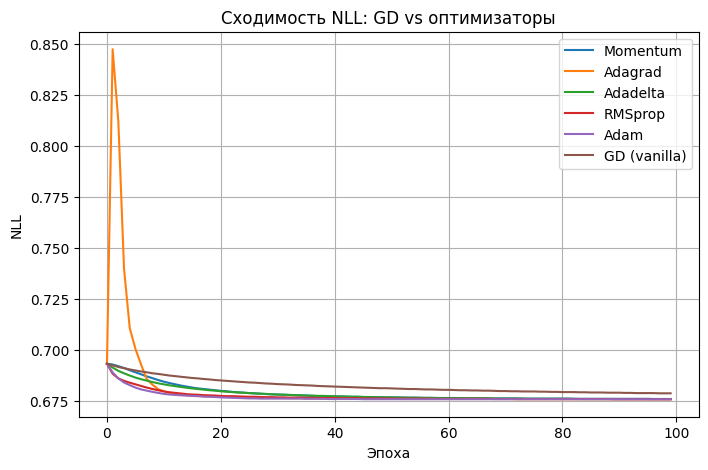

In [33]:
# Визуализация сходимости NLL для GD и оптимизаторов
plt.figure(figsize=(8, 5))

for name, hist in results_opt.items():
    plt.plot(hist, label=name)

plt.title("Сходимость NLL: GD vs оптимизаторы")
plt.xlabel("Эпоха")
plt.ylabel("NLL")
plt.legend()
plt.grid(True)
plt.show()


В RMSprop наблюдается всплеск на старте из-за маленького eps

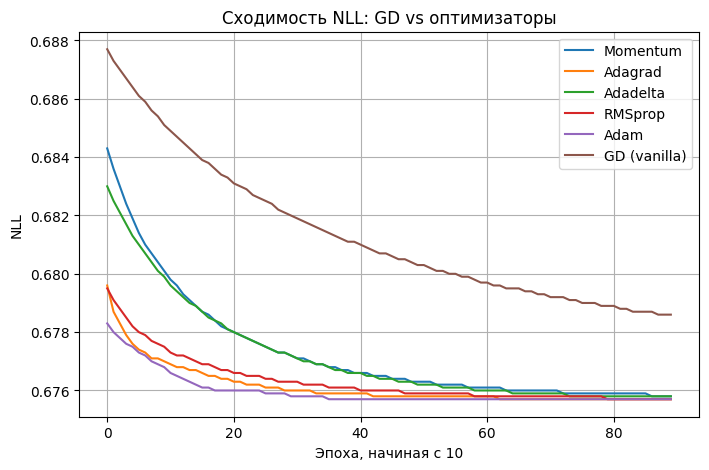

In [34]:
# Визуализация сходимости NLL для GD и оптимизаторов
plt.figure(figsize=(8, 5))

for name, hist in results_opt.items():
    plt.plot(hist[10:], label=name)

plt.title("Сходимость NLL: GD vs оптимизаторы")
plt.xlabel("Эпоха, начиная с 10")
plt.ylabel("NLL")
plt.legend()
plt.grid(True)
plt.show()


Сравнение GD и адаптивных оптимизаторов

- **Скорость сходимости**: Adam, Adagrad, Adadelta и RMSprop, как правило, быстрее уменьшают NLL в первые эпохи по сравнению с классическим GD, поскольку автоматически подстраивают шаг обучения под масштаб градиентов по каждому признаку
- **Стабильность**: Momentum сглаживает траекторию по сравнению с чистым GD, но может давать небольшие колебания; адаптивные методы (особенно Adam и Adadelta) ведут себя более стабильно
- **Финальное значение потерь**: при разумном подборе гиперпараметров все рассмотренные адаптивные оптимизаторы дают сопоставимые или более низкие значения NLL, чем ванильный GD
- **Практический вывод**: для задач вроде данной бинарной классификации удобнее всего использовать Adam с параметрами по умолчанию - он быстро сходится и мало чувствителен к масштабу признаков, тогда как GD требует аккуратного подбора learning rate


# Задание 4

Рассмотрим датасет по предсказанию года создания песни по числовым признакам. Информацию о датасете можно найти здесь:

- https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD#
- http://labrosa.ee.columbia.edu/millionsong
- https://en.wikipedia.org/wiki/Timbre

**Ссылка**: https://www.kaggle.com/t/506c3b7cd9c24937ae8fb2f50fedf5dd

Мы используем поднабор этого датасета. Пожалуйста, не используйте исходный датасет для читинга, за это получите 0 за ВООБЩЕ всю домашку. Это задание организовано с помощью соревнования на kaggle. Попробуйте обучить нейронную сеть (используя линейные и другие слои, возможную нормализацию и активации). Можете использовать любые методы предобработки данных и фокусы, кроме ансамблирования и использования сторонних источников ДАННЫХ.

- Задание обязательно, базовое максимальное число баллов - 6.
- Топ 25% получат +3 балла, топ 50 +2 балла, топ 75 +1 балл.
- Решение должно быть уникальным, необходимо предоставить код и описание решения. Если использованы внешние источники (туториалы, статьи и т.п.), необходимо предоставить ссылки.
- Обучите модель, используя ваш кастомный оптимизатор. Это даст еще 1 балл. Покажите, изменилось ли что-то.
- При решении задачи можно использовать любые встренные в torch модули (nn, optim, transforms, etc)
- Можно использовать numpy, sklearn, pandas ТОЛЬКО для предобработки и постобработки решения (сборки сабмишена). Для самой модели можно использовать только torch.
- При переобучении можно добавить dropout, batchnorm итд.

In [ ]:
from __future__ import annotations

import os
import time
from typing import Any, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [ ]:
TRAIN_X = "train_x.csv"
TRAIN_Y = "train_y.csv"
TEST_X = "test_x.csv"
SUBMISSION_OUT = "submission.csv"

YEAR_MIN = 1922
YEAR_MAX = 2011

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
x_df = pd.read_csv(TRAIN_X, index_col=0)
y_df = pd.read_csv(TRAIN_Y, index_col=0)

# read test WITHOUT index_col and take the last column as id
test_df_full = pd.read_csv(TEST_X)
id_col = test_df_full.columns[-1]

test_indices = test_df_full[id_col].to_numpy()
X_test = test_df_full.drop(columns=[id_col]).values.astype(np.float32)

y_df = y_df.reindex(x_df.index)

X = x_df.values.astype(np.float32)
y = y_df["year"].values.astype(np.float32)

df = pd.concat([x_df, test_df_full.drop(columns=[id_col])], ignore_index=True)

print("Shapes (X, y, X_test):", X.shape, y.shape, X_test.shape)

Shapes (X, y, X_test): (14000, 90) (14000,) (6000, 90)


In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,37.47518,-14.34414,40.54872,-9.10171,16.77175,-17.77113,-16.50156,-4.09543,2.49723,-0.46428,...,104.03557,-115.62803,-13.79660,31.60436,28.95927,-25.93164,67.64670,-25.76691,-81.90373,-61.48682
1,48.17393,-7.02208,-30.36086,-2.41924,2.15406,-8.44502,-1.68191,-8.71434,-7.83802,-5.58019,...,11.58664,24.58950,-36.95682,0.73922,-0.06330,53.75838,-81.05330,8.42811,12.08694,-1.91676
2,36.58141,26.03203,-4.92774,35.71620,8.53080,3.73167,-7.98443,-7.43976,-1.69797,10.75028,...,23.61190,-366.07968,-62.38201,113.48188,4.72741,181.64459,-134.46216,8.50795,94.15573,-8.47276
3,41.15615,-17.77029,-32.30961,-21.03778,12.80330,-13.48031,-3.14951,-7.62647,-4.48901,-4.29075,...,25.11398,-79.64532,-77.08169,38.88094,28.52025,24.17783,-86.62542,-1.19418,-74.73449,-17.28130
4,40.54855,78.77563,-23.29877,98.60192,-30.11496,26.94220,-8.87771,-3.23280,-1.04841,31.69655,...,-9.89388,-252.61021,118.93768,-155.87390,51.85666,-365.15815,59.34936,52.47311,99.00695,-10.18840


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 90 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20000 non-null  float64
 1   1       20000 non-null  float64
 2   2       20000 non-null  float64
 3   3       20000 non-null  float64
 4   4       20000 non-null  float64
 5   5       20000 non-null  float64
 6   6       20000 non-null  float64
 7   7       20000 non-null  float64
 8   8       20000 non-null  float64
 9   9       20000 non-null  float64
 10  10      20000 non-null  float64
 11  11      20000 non-null  float64
 12  12      20000 non-null  float64
 13  13      20000 non-null  float64
 14  14      20000 non-null  float64
 15  15      20000 non-null  float64
 16  16      20000 non-null  float64
 17  17      20000 non-null  float64
 18  18      20000 non-null  float64
 19  19      20000 non-null  float64
 20  20      20000 non-null  float64
 21  21      20000 non-null  float64
 22

90 колонок с 20к значений типа float64 без пропусков

In [ ]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,43.378019,1.186399,8.431117,1.309199,-6.550490,-9.471295,-2.240024,-1.680605,3.583162,1.902104,...,15.814596,-73.816157,40.965066,37.911683,0.113929,17.628532,-28.006010,4.464964,19.345221,1.415733
std,6.039260,51.860345,35.856147,16.553635,22.844339,12.924235,14.680020,7.994316,10.618999,6.593382,...,32.571452,174.964318,121.236064,95.877677,16.049954,113.439592,179.180997,13.502248,185.561383,22.036478
min,7.199890,-325.401880,-257.525600,-120.723150,-142.160680,-70.693420,-100.602550,-51.443820,-75.539550,-31.344160,...,-224.101380,-4402.376440,-921.354400,-1237.931680,-227.608010,-2678.193680,-3059.906060,-191.640380,-5000.654060,-286.031200
25%,39.975808,-26.009810,-11.691437,-8.473990,-20.736248,-18.403858,-10.640050,-6.414370,-2.526207,-2.440438,...,-1.824178,-139.806130,-21.370213,-4.776555,-6.993642,-31.640648,-102.143433,-2.537718,-59.407007,-8.709190
50%,44.256625,8.657085,10.306305,-0.584900,-5.786110,-11.190585,-2.024060,-1.554760,3.678620,1.773915,...,9.197415,-54.277160,29.198955,33.231000,0.758455,16.058740,-21.783635,3.026920,7.754300,0.072650
75%,47.808940,36.507593,29.633405,9.004565,7.835335,-2.250980,6.665885,3.031610,9.975827,6.209783,...,26.327127,13.236852,89.581750,78.132970,8.358058,66.726465,50.481678,9.923355,86.482015,9.774505
max,57.408630,240.617010,318.868960,143.841600,142.305480,68.300090,147.965260,52.331120,78.149440,36.596180,...,840.973380,1295.063120,1649.415470,1458.580210,199.121500,1620.749740,1879.332480,352.359540,3165.372860,245.209770


Pначения сильно варьируются и содержат широкий диапазон разбросов и экстремальных значений

<Axes: >

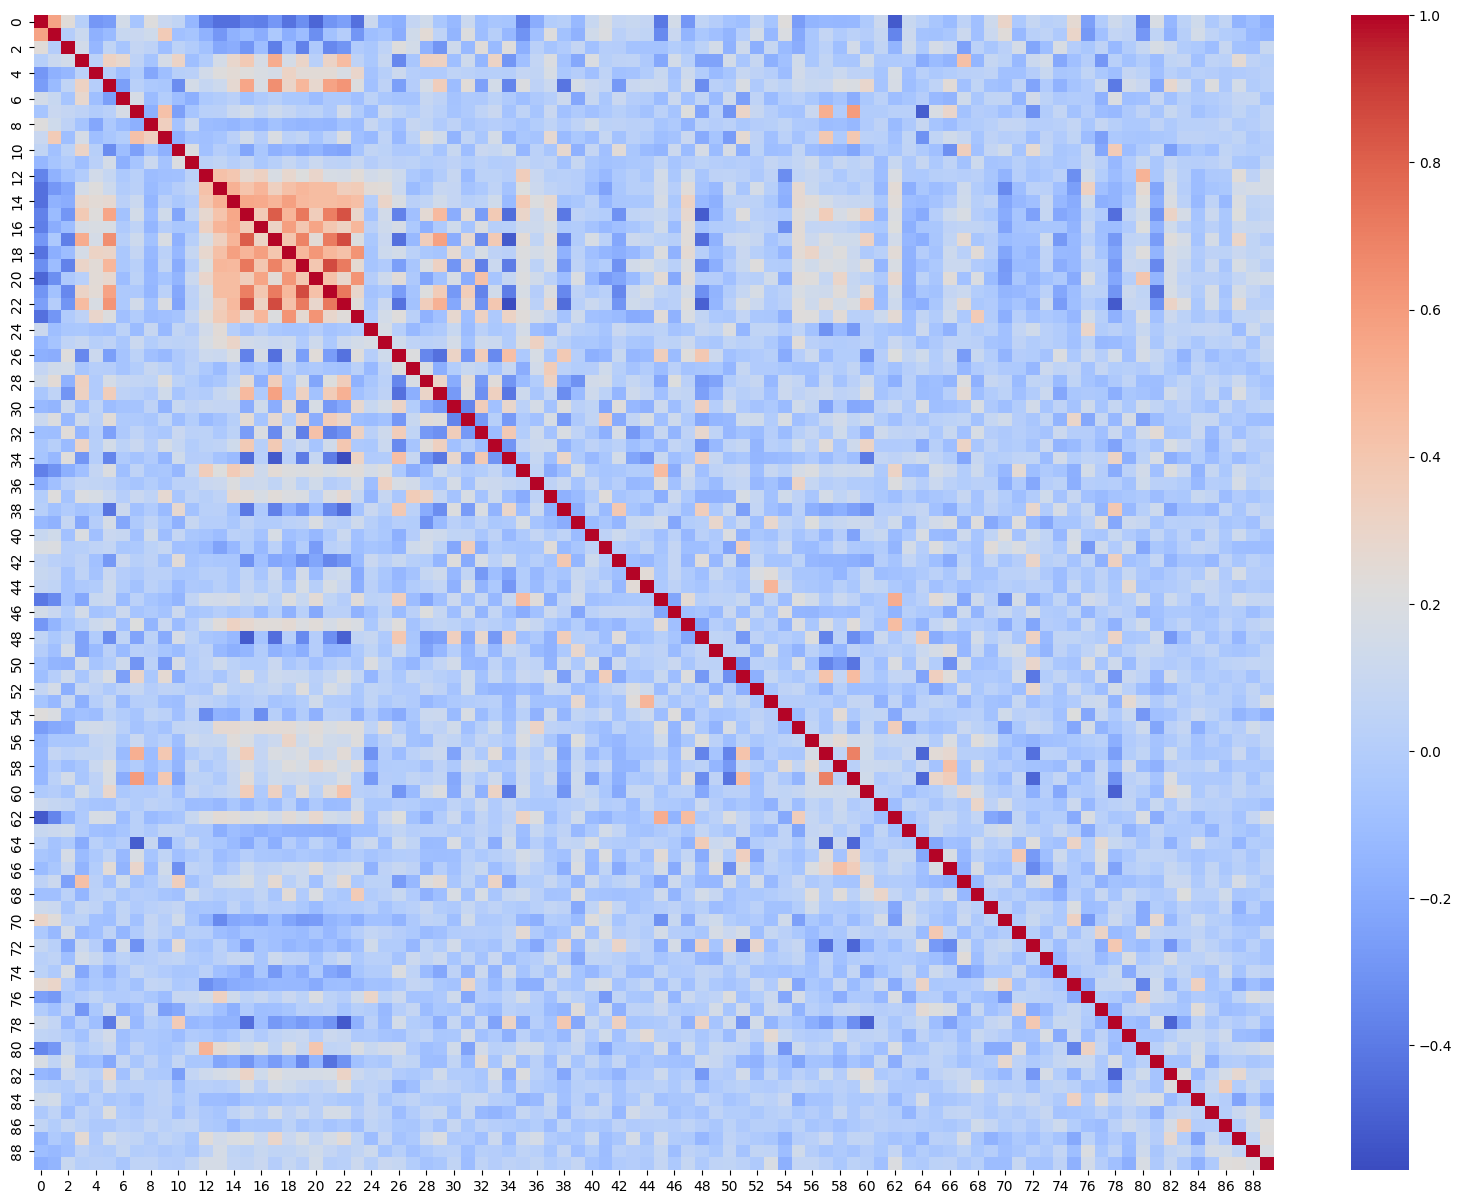

In [ ]:
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), cmap="coolwarm")


In [ ]:
# Preprocessing (impute + scale)
imp = SimpleImputer(strategy="median")
X = imp.fit_transform(X)
X_test = imp.transform(X_test)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

Заполняем пропуски медианой и приводим все признаки к одному масштабу, чтобы модели лучше обучались и не страдали от разницы в масштабах аудио-фич

In [ ]:
# Center target (optional)
year_mean = float(y.mean())
y_centered = y - year_mean
print("Target mean:", year_mean)

Target mean: 1998.36669921875


Вычитаем среднее из целевой переменной, чтобы модель обучалась на более нормализованном таргете

In [ ]:
# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_centered, test_size=0.15, random_state=42, shuffle=True
)

In [ ]:
class YearDataset(Dataset):
    """Dataset that returns X or (X, y)."""

    def __init__(self, X: np.ndarray, y: np.ndarray | None = None):
        self.X = torch.from_numpy(X).float()
        self.y = None if y is None else torch.from_numpy(y).float()

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> Any:
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]

Класс преобразует массивы numpy в тензоры pytorch, чтобы легко загружать данные в модель во время обучения и тестирования

In [ ]:
# Dataloaders
batch_size = 1024 if torch.cuda.is_available() else 512
train_loader = DataLoader(
    YearDataset(X_train, y_train),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)
val_loader = DataLoader(
    YearDataset(X_val, y_val), batch_size=batch_size, shuffle=False, num_workers=0
)
test_loader = DataLoader(
    YearDataset(X_test, None), batch_size=2048, shuffle=False, num_workers=0
)

Подаем данные батчами в модель для ускорения обучения

In [ ]:
class ResidualBlock(nn.Module):
    """Residual block with BN, SiLU and dropout."""

    def __init__(self, in_dim: int, out_dim: int, p_drop: float = 0.2):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, out_dim)
        self.bn1 = nn.BatchNorm1d(out_dim)
        self.act = nn.SiLU()
        self.drop = nn.Dropout(p_drop)
        self.fc2 = nn.Linear(out_dim, out_dim)
        self.bn2 = nn.BatchNorm1d(out_dim)
        self.res = nn.Linear(in_dim, out_dim) if in_dim != out_dim else None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.fc1(x)
        h = self.bn1(h)
        h = self.act(h)
        h = self.drop(h)
        h = self.fc2(h)
        h = self.bn2(h)
        if self.res is not None:
            x = self.res(x)
        return self.act(h + x)

`ResidualBlock` помогает глубоким нейронным сетям решать проблемы исчезающих градиентов и облегченать обучение. Он позволяет информации "пропускать" несколько слоев (skip connection), добавляя входной тензор к выходу внутренних слоев (`h + x`)

**Компоненты блока:**

*   `nn.Linear`: Полносвязные слои для преобразования признаков
*   `nn.BatchNorm1d`: Batch Normalization для стабилизации и ускорения обучения
*   `nn.SiLU()`: Активационная функция для внесения нелинейности
*   `nn.Dropout`: Регуляризация для предотвращения переобучения
*   **Skip Connection:** Прямое добавление входных данных (`x`) к выходу блока, иногда с линейным преобразованием (`self.res`) для согласования размерностей

In [ ]:
class Net(nn.Module):
    """Regression network for year prediction."""

    def __init__(self, in_dim: int):
        super().__init__()
        self.in_drop = nn.Dropout(0.05)
        self.fc_in = nn.Linear(in_dim, 1024)
        self.bn_in = nn.BatchNorm1d(1024)
        self.block1 = ResidualBlock(1024, 1024, p_drop=0.3)
        self.block2 = ResidualBlock(1024, 512, p_drop=0.25)
        self.block3 = ResidualBlock(512, 256, p_drop=0.2)
        self.head = nn.Sequential(
            nn.Linear(256, 64),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.in_drop(x)
        x = self.fc_in(x)
        x = self.bn_in(x)
        x = torch.nn.functional.silu(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return self.head(x).squeeze(1)

Архитектура модели `Net`

- **Dropout(0.05)** - лёгкая регуляризация входных фич
- **Linear(in_dim -> 1024) + BatchNorm** - расширяем пространство признаков для захвата сложных зависимостей
- **Слои: 1024 -> 1024 -> 512 -> 256** - сначала широкая часть, затем сжатие к компактному представлению
- **Head: 256 -> 64 -> 1 + SiLU + Dropout** - финальная регрессия с устойчивым предсказанием
- **`squeeze(1)`** - приводит вывод к форме `(batch,)` для MSELoss

Архитектура выбрана как «широкая -> сжимающаяся», что хорошо работает для нелинейных задач регрессии по аудио-фичам


In [ ]:
class CustomOptimizer(torch.optim.Optimizer):
    """Custom optimizer: momentum + running squared grads (RMS-like)."""

    def __init__(
        self,
        params,
        lr: float = 5e-4,  # небольшое значение для стабильной сходимости с кастомным оптимизатором
        momentum: float = 0.9,  # ускоряет сходимость за счёт накопления предыдущих градиентов
        beta: float = 0.999,  # коэффициент усреднения квадратов градиентов (RMS-подобное сглаживание)
        eps: float = 1e-8,  # предотвращает деление на ноль
        weight_decay: float = 0.0,  # пока без L2-регуляризации, чтобы не мешать обучению
    ):
        defaults = dict(
            lr=lr,
            momentum=momentum,
            beta=beta,
            eps=eps,
            weight_decay=weight_decay,
        )
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure: Any = None) -> None:
        if closure is not None:
            closure()
        for group in self.param_groups:
            lr = group["lr"]
            momentum = group["momentum"]
            beta = group["beta"]
            eps = group["eps"]
            wd = group["weight_decay"]
            for p in group["params"]:
                if p.grad is None:
                    continue
                g = p.grad
                if wd != 0:
                    g = g.add(p, alpha=wd)
                state = self.state[p]
                if "mom" not in state:
                    state["mom"] = torch.zeros_like(p)
                    state["sq"] = torch.zeros_like(p)
                mom = state["mom"]
                sq = state["sq"]
                sq.mul_(beta).addcmul_(g, g, value=1.0 - beta)
                denom = sq.sqrt().add_(eps)
                mom.mul_(momentum).addcdiv_(g, denom)
                p.add_(mom, alpha=-lr)

CustomOptimizer сглаживает шум градиентов и автоматически подстраивает шаг под масштаб каждого параметра

- Основан на идее **momentum + адаптивный шаг**
- **momentum** - сглаживает направление градиента
- **running squared grads (sq)** - хранит скользящее среднее квадрата градиента, делает шаги адаптивными
- **weight decay** - L2-регуляризация
- Обновление параметров:  
  1) обновляем `sq` <- β * sq + (1 - β) * g²  
  2) считаем шаг g / sqrt(sq + eps)  
  3) применяем momentum
  4) обновляем параметры p <- p - lr * mom

In [ ]:
# Model / optimizer / loss
model = Net(X_train.shape[1]).to(device)
print("Model params:", sum(p.numel() for p in model.parameters()))
optimizer = CustomOptimizer(
    model.parameters(), lr=5e-4, momentum=0.9, beta=0.999, weight_decay=1e-5
)
criterion = nn.MSELoss()

Model params: 3858817


In [ ]:
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    """Compute MSE on loader (expects loader to yield (x, y))."""
    model.eval()
    total = 0.0
    n = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (list, tuple)):
                xb, yb = batch
            else:
                raise RuntimeError("Validation loader must return (x, y).")
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            total += loss.item() * xb.size(0)
            n += xb.size(0)
    return total / n if n > 0 else float("inf")

Вычисляет среднюю MSE модели на даталоадере с отключённым обучением и градиентами

In [ ]:
# Training
best_val = float("inf")
best_epoch = 0
epochs = 60
patience = 10

train_history = []
val_history = []

for epoch in range(1, epochs + 1):
    t0 = time.time()
    model.train()
    running = 0.0
    n = 0
    for batch in train_loader:
        if isinstance(batch, (list, tuple)):
            xb, yb = batch
        else:
            raise RuntimeError("Train loader must return (x, y).")
        xb = xb.to(device)
        yb = yb.to(device)

        preds = model(xb)
        loss = criterion(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
        optimizer.step()

        running += loss.item() * xb.size(0)
        n += xb.size(0)

    train_mse = running / n if n > 0 else 0.0
    val_mse = evaluate(model, val_loader, device)
    elapsed = time.time() - t0

    print(
        f"Epoch {epoch:02d} | train MSE: {train_mse:.4f} | "
        f"val MSE: {val_mse:.4f} | time: {elapsed:.1f}s | lr: {optimizer.param_groups[0]['lr']:.6g}"
    )

    if val_mse + 1e-9 < best_val:
        best_val = val_mse
        best_epoch = epoch
        torch.save(model.state_dict(), "best_model.pth")
        print("  Saved best model.")
    else:
        # reduce lr on plateau for custom optimizer (simple rule)
        if (epoch - best_epoch) % 4 == 0 and (epoch - best_epoch) > 0:
            for g in optimizer.param_groups:
                g["lr"] = g["lr"] * 0.5
            print("  Reduced lr to", optimizer.param_groups[0]["lr"])

    if epoch - best_epoch >= patience:
        print("Early stopping. Best val MSE:", best_val, "at epoch", best_epoch)
        break

    train_history.append(train_mse)
    val_history.append(val_mse)

Epoch 01 | train MSE: 548.3506 | val MSE: 273.7805 | time: 0.3s | lr: 0.0005
  Saved best model.
Epoch 02 | train MSE: 124.5333 | val MSE: 124.4569 | time: 0.2s | lr: 0.0005
  Saved best model.
Epoch 03 | train MSE: 114.2521 | val MSE: 154.1853 | time: 0.2s | lr: 0.0005
Epoch 04 | train MSE: 119.7568 | val MSE: 91.5563 | time: 0.2s | lr: 0.0005
  Saved best model.
Epoch 05 | train MSE: 99.8143 | val MSE: 89.1317 | time: 0.2s | lr: 0.0005
  Saved best model.
Epoch 06 | train MSE: 99.4155 | val MSE: 92.8174 | time: 0.2s | lr: 0.0005
Epoch 07 | train MSE: 92.9544 | val MSE: 83.7920 | time: 0.2s | lr: 0.0005
  Saved best model.
Epoch 08 | train MSE: 90.2744 | val MSE: 104.4677 | time: 0.2s | lr: 0.0005
Epoch 09 | train MSE: 102.2069 | val MSE: 94.9594 | time: 0.2s | lr: 0.0005
Epoch 10 | train MSE: 95.2958 | val MSE: 86.2832 | time: 0.4s | lr: 0.0005
Epoch 11 | train MSE: 88.1809 | val MSE: 82.6212 | time: 0.2s | lr: 0.0005
  Saved best model.
Epoch 12 | train MSE: 86.5813 | val MSE: 83.45

- Обучение модели на `train_loader` с вычислением MSE на каждом батче
- **clip_grad_norm_(3.0)** - ограничивает градиенты для стабильного обучения  
- **Reduce LR on plateau** - если валидация не улучшается 4 эпохи, уменьшаем шаг обучения в 2 раза
- **Early stopping (patience=10)** - прекращаем обучение, если улучшений нет длительное время

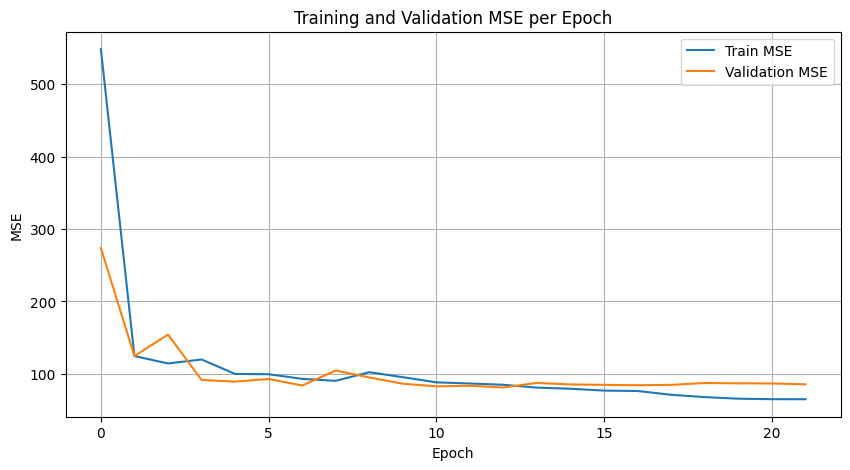

In [ ]:
# Plot train/val MSE
plt.figure(figsize=(10, 5))
plt.plot(train_history, label="Train MSE")
plt.plot(val_history, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training and Validation MSE per Epoch")
plt.legend()
plt.grid(True)
plt.show()

Train MSE ниже, чем Validation MSE - модель немного переобучается, но не критично

In [ ]:
# Inference
print("Loading best model and running inference...")
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()
preds_list = []
with torch.no_grad():
    for batch in test_loader:
        xb = batch if not isinstance(batch, (list, tuple)) else batch[0]
        xb = xb.to(device)
        out = model(xb).cpu().numpy()
        preds_list.append(out)

Loading best model and running inference...


In [ ]:
preds = np.concatenate(preds_list, axis=0)
preds = preds + year_mean
years = np.round(preds).astype(int)
years = np.clip(years, YEAR_MIN, YEAR_MAX)

if len(years) != len(test_indices):
    raise RuntimeError("Length of predictions and test ids mismatch.")

In [ ]:
submission = pd.DataFrame({"index": test_indices, "year": years})
submission

,index,year
0,3416,2000
1,18991,2005
2,11105,2001
3,18902,2001
4,18958,2003
...,...,...
5995,15293,2002
5996,7469,1991
5997,6586,1986
5998,17875,1993


In [ ]:
submission.to_csv(SUBMISSION_OUT, index=False)
print("Saved submission to", SUBMISSION_OUT, "| rows:", len(submission))

Saved submission to submission.csv | rows: 6000
